# Project PTMs onto ESRP1 knockdown data from MATS (Yang et al, 2016)

Here is an example of running PTM-POSE on MATS analysis of RNA sequencing data from ESRP1 knockdown experiments performed by Yang et al. ([link to paper](https://www.tandfonline.com/doi/full/10.1128/MCB.00019-16)). 

First, let's focus on skipped exon events.

## Phase 1: Load the data and initialize PTM-POSE
 To identify differentially included PTMs as a result of ESRP1 knockdown, we need three layers of information for each splice event: 
1. Chromosome
2. DNA strand
2. Start and end coordinates of the event (either hg19 or hg38)

Optionally, we can also provide:
1. Gene name
2. Event ID
3. Delta PSI for the event
4. Significance of the event

With PTM-POSE, we need to indicate where to find this information within the splice data

In [1]:
import pandas as pd

SE_data = pd.read_excel('../../ESRP1_data/Yang2016/esrp1_knockdown_data_Yang2016.xlsx', sheet_name='rMATS ESRP KD', header = 2).iloc[0:179]


# required column information
chromosome_col = 'chr'
strand_col = 'strand'
region_start_col = 'exonStart_0base'
region_end_col = 'exonEnd'

# optional column information (None if nothing is provided and will not be appended to the output)
gene_col = 'geneSymbol'
event_id_col = None   #not in the data
dPSI_col = 'meanDeltaPSI'
sig_col = 'FDR'

#look at the data
SE_data[[gene_col, chromosome_col, strand_col, region_start_col, region_end_col, dPSI_col, sig_col]].head()

,geneSymbol,chr,strand,exonStart_0base,exonEnd,meanDeltaPSI,FDR
0,SPAG9,chr17,-,49053223,49053262,0.227,0
1,ARHGAP17,chr16,-,24950684,24950918,0.413,0
2,ITGA6,chr2,+,173366499,173366629,-0.361,0
3,KRAS,chr12,-,25368370,25368494,-0.068,0
4,TCIRG1,chr11,+,67817953,67818131,0.368,0


The strand can either be provided use '+' and '-' or using 1 and -1 to indicate the forward and reverse strand, the code will convert strand to integer format (-1 or 1) when running.

If this is the first time running PTM-POSE, you will need to download ptm_coordinates. If you set save = True, the coordinates will be saved for the future so you do not need to redownload them, but you can also set save = False to avoid saving the coordinates (will take ~60MB of space)

In [3]:
from ptm_pose import pose_config
pose_config.ptm_coordinates = pose_config.download_ptm_coordinates(save = True)

## Phase 2: Project PTMs onto differentially included regions

 We can then use the project module of PTM-POSE to identify PTMs that can be found in these regions. This dataset uses the hg19 genome build, so we need to specify this using the 'coordinate_type' parameter.

In [2]:
from ptm_pose import project

splice_data, spliced_ptms = project.project_ptms_onto_splice_events(SE_data, chromosome_col = chromosome_col, strand_col = strand_col, region_start_col = region_start_col, region_end_col = region_end_col, gene_col = gene_col, event_id_col = event_id_col, dPSI_col = dPSI_col, sig_col = sig_col, coordinate_type = 'hg19')

Translator file not found. Downloading mapping information between UniProt and Gene Names from pybiomart


Projecting PTMs onto splice events using hg19 coordinates.: 100%|██████████| 179/179 [00:03<00:00, 48.82it/s]

PTMs projection successful (475 identified).



From this, there are two outputs:
1. The original splice dataframe with additional PTM information added

In [4]:
splice_data[[gene_col, chromosome_col, strand_col, region_start_col, region_end_col, dPSI_col, sig_col] + ['PTMs', 'Number of PTMs Affected', 'Number of Unique PTM Sites by Position', 'Event Length', 'PTM Density (PTMs/bp)']].head()

,geneSymbol,chr,strand,exonStart_0base,exonEnd,meanDeltaPSI,FDR,PTMs,Number of PTMs Affected,Number of Unique PTM Sites by Position,Event Length,PTM Density (PTMs/bp)
0,SPAG9,17,-,49053223,49053262,0.227,0,NaN,0,0,39,0.0
1,ARHGAP17,16,-,24950684,24950918,0.413,0,Q68EM7_S575.0 (Phosphorylation)/Q68EM7_S570.0 ...,6,1,234,0.004274
2,ITGA6,2,+,173366499,173366629,-0.361,0,P23229_Ynan (Phosphorylation)/P23229_Tnan (Pho...,7,4,130,0.030769
3,KRAS,12,-,25368370,25368494,-0.068,0,P01116_C186 (Methylation)/P01116_C180 (Palmito...,3,2,124,0.016129
4,TCIRG1,11,+,67817953,67818131,0.368,0,NaN,0,0,178,0.0


2. New dataframe that has each PTM and additional information about the PTM in its own row

In [5]:
spliced_ptms.head()

,dPSI,Significance,Gene,Source of PTM,UniProtKB Accession,Residue,PTM Position in Canonical Isoform,Gene Location (hg19),Modification,Modification Class,Proximity to Region Start (bp),Proximity to Region End (bp),Proximity to Splice Boundary (bp)
0,0.413,0.0,ARHGAP17,Q68EM7-1_S575,Q68EM7,S,575.0,24950686.0,Phosphoserine,Phosphorylation,2.0,232.0,2.0
1,0.413,0.0,ARHGAP17,Q68EM7-1_S570,Q68EM7,S,570.0,24950701.0,Phosphoserine,Phosphorylation,17.0,217.0,17.0
2,0.413,0.0,ARHGAP17,Q68EM7-1_S560,Q68EM7,S,560.0,24950731.0,Phosphoserine,Phosphorylation,47.0,187.0,47.0
3,0.413,0.0,ARHGAP17,Q68EM7-1_S553,Q68EM7,S,553.0,24950752.0,Phosphoserine,Phosphorylation,68.0,166.0,68.0
4,0.413,0.0,ARHGAP17,Q68EM7-1_S547,Q68EM7,S,547.0,24950770.0,Phosphoserine,Phosphorylation,86.0,148.0,86.0


For MATS data, there is also a built in function for running PTM-POSE on MATS data, including all events: 

## Phase 3: Identify PTMs with altered flanking sequences as a result of splice events

In addition to differential inclusion of PTMs, some PTMs may experience altered flanking sequences. We can use the project module of PTM-POSE to identify PTMs for which this happens. You will need to provide the same layers of information, plus the genomic coordinates of the regions flanking the spliced region.

In [12]:
from ptm_pose import flanking_sequences

first_flank_start_col = 'firstFlankingES'
first_flank_end_col='firstFlankingEE'
second_flank_start_col = 'secondFlankingES'
second_flank_end_col = 'secondFlankingEE'

flanks = flanking_sequences.get_flanking_changes_from_splice_data(SE_data, chromosome_col = chromosome_col, strand_col = strand_col, first_flank_start_col = first_flank_start_col, first_flank_end_col=first_flank_end_col, second_flank_start_col = second_flank_start_col, second_flank_end_col = second_flank_end_col , spliced_region_start_col = region_start_col, spliced_region_end_col = region_end_col, dPSI_col=dPSI_col, sig_col = sig_col, event_id_col = event_id_col, coordinate_type = 'hg19')

c:\Users\Sam\miniconda3\envs\testing_pose\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
flanks.head()

,Event ID,Source of PTM,Residue,PTM Position in Canonical Isoform,Inclusion Sequence,Exclusion Sequence,Region,Translation Success,Matched
0,3,P01116-2_T148;P01116-1_T148,T,148,ETSAKtRQESG,ETSAKtRQGC*,Second,True,False
1,3,P01116-1_K147;P01116-2_K147,K,147,IETSAkTRQES,IETSAkTRQGC,Second,True,False
0,8,Q9UPQ0-1_S746,S,746,LPNLNsQGVAW,LPNLNsQGGFS,First,True,False
1,8,Q9UPQ0-10_S750;Q9UPQ0-6_S596;Q9UPQ0-1_S750,S,750,PSQVDsPSSEK,ILKVDsPSSEK,Second,True,False
0,11,P62847-1_K129,K,NaN,NVGAGkKSVSW,NVGAGkKAEGV,First,True,False


We can also do additional comparisons, such as comparing sequence identity and looking for matching elm motifs.

In [ ]:
flanks = flanking_sequences.compare_flanking_sequences(flanks)
flanks = flanking_sequences.compare_inclusion_motifs(flanks)
flanks[['Source of PTM','Sequence Identity', 'Altered Positions','Residue Changes', 'Altered Flank Side', 'Motif only in Inclusion', 'Motif only in Exclusion']].head()

## Phase 4: Annotate PTMs with functional information

Once we have PTMs impacted by splicing, we can also annotate them with additional information. This can be done using the annotate module of PTM-POSE, and can be used with outputs from either the project module (differentially included PTMs) or the flanking_sequence module (PTMs with altered flanking sequences).

Currently, there are functions for appending information from:
1. PhosphoSitePlus (function, biological process, disease association, interactions, and kinase-substrate), 
2. RegPhos (kinase-substrate), 
3. PTMcode (inter and intraprotein interactions)
4. PTMInt (interactions)
5. DEPOD (Phosphatase-substrate)
6. ELM (interactions, motifs)

In [3]:
from ptm_pose import annotate

#PhosphoSitePlus data (due to licencsing issues, must be downloaded manually from PhosphoSitePlus and the file path provided)
spliced_ptms = annotate.add_PSP_regulatory_site_data(spliced_ptms, '/PhosphoSitePlus/Regulatory_sites.gz')
spliced_ptms = annotate.add_PSP_disease_association(spliced_ptms, '/PhosphoSitePlus/Disease-associated_sites.gz')
spliced_ptms = annotate.add_PSP_kinase_substrate_data(spliced_ptms, '/Database_Information/PhosphoSitePlus/Kinase_Substrate_Dataset.gz')

#ELM interactions (will be faster if file is downloaded manually from ELM and the file path provided)
spliced_ptms = annotate.add_ELM_interactions(spliced_ptms)

#PTMint interactions
spliced_ptms = annotate.add_PTMint_data(spliced_ptms)

#PTMcode interactions (will be faster/more reliable if file is downloaded manually from PTMcode and the file path provided)
spliced_ptms = annotate.add_PTMcode_interprotein(spliced_ptms, fname = 'PTMcode2_associations_between_proteins.txt.gz')

#DEPOD phosphatase data
spliced_ptms = annotate.add_DEPOD_phosphatase_data(spliced_ptms)

#RegPhos data
spliced_ptms = annotate.add_RegPhos_data(spliced_ptms)

PhosphoSitePlus regulatory_site information added:
	 ->6 PTMs in dataset found associated with a molecular function 
	 ->7 PTMs in dataset found associated with a biological process
	 ->2 PTMs in dataset found associated with a protein interaction
PhosphoSitePlus disease associations added: 1 PTM sites in dataset found associated with a disease in PhosphoSitePlus
PhosphoSitePlus kinase-substrate interactions added: 6 phosphorylation sites in dataset found associated with a kinase in PhosphoSitePlus
ELM interaction instances added: 1 PTMs in dataset found associated with at least one known ELM instance
PTMInt data added: 2 PTMs in dataset found with PTMInt interaction information
PTMcode interprotein interactions added: 27 PTMs in dataset found with PTMcode interprotein interaction information
DEPOD Phosphatase substrates added: 0 PTMs in dataset found with Phosphatase substrate information
RegPhos kinase-substrate data added: 3 PTMs in dataset found with kinase-substrate information


c:\Users\Sam\miniconda3\envs\testing_pose\Lib\site-packages\ptm_pose\annotate.py:558: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  regphos = pd.read_csv('http://140.138.144.141/~RegPhos/download/RegPhos_Phos_human.txt', sep = '\t')


## Phase 5: Analyze Results

Once we have all of this information, we can start to assess how PTMs are impacted by splicing. Let's first get an idea for how many PTMs have different annotations associated with them from the various sources

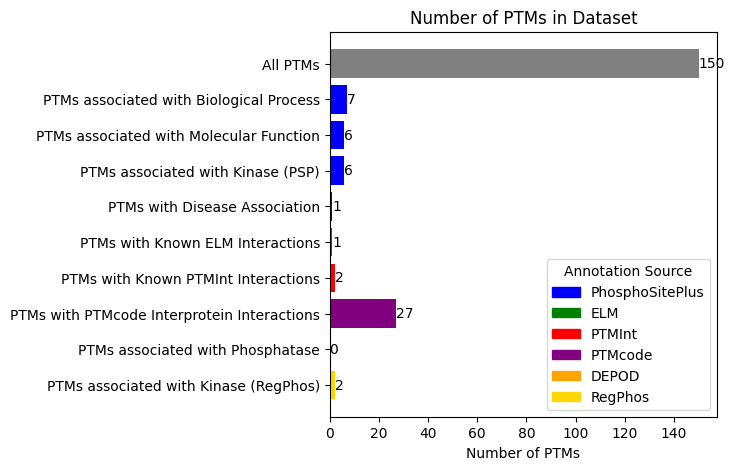

In [6]:
from ptm_pose import analyze

analyze.show_available_annotations(spliced_ptms, figsize = (5,5))

There are several ptms that have previously been annotated with specific functions, let's take a look at those:

In [10]:
annotations, annotation_counts = analyze.get_ptm_annotations(spliced_ptms, annotation_type = 'Process', database = 'PhosphoSitePlus')
annotations.head()

,Gene,UniProtKB Accession,Residue,PTM Position in Canonical Isoform,Modification Class,PSP:ON_PROCESS
145,CEACAM1,P13688,S,461.0,Phosphorylation,"apoptosis, altered"
184,YAP1,P46937,K,342.0,Ubiquitination,"carcinogenesis, altered"
217,TSC2,P49815,S,981.0,Phosphorylation,"carcinogenesis, inhibited; cell growth, inhibi..."
395,SPHK2,Q9NRA0,S,387.0,Phosphorylation,"cell motility, altered"
407,SPHK2,Q9NRA0,T,614.0,Phosphorylation,"cell motility, altered"


In [11]:
annotation_counts

,PSP:ON_PROCESS,count
0,"cell motility, altered",3
1,"cell growth, induced",2
2,"apoptosis, altered",1
3,"carcinogenesis, altered",1
4,"carcinogenesis, inhibited",1
5,"cell growth, inhibited",1
6,"autophagy, inhibited",1
7,signaling pathway regulation,1
8,cytoskeletal reorganization,1
9,"cell adhesion, inhibited",1
